<a href="https://colab.research.google.com/github/balwanishivam/tml-assignment/blob/Assignment-2/TML_assignment_2_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_model_stealing = '/content/drive/MyDrive/TML_EncoderStealing/ModelStealingPub.pt'

In [ ]:
encoder_rep = '/content/drive/MyDrive/TML_EncoderStealing/representation.pt'

In [ ]:
import torch
from typing import Tuple
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt



<class 'tuple'>
('40019202', '10964686', '62225416', '26466207', '24683694', '26466207', '90386222', '15103694', '62225416', '14119474', '62225416', '75986657', '62014378', '90386222', '15103694', '62225416', '62225416', '62014378', '15103694', '14119474', '26466207', '62225416', '15103694', '15256249', '14119474', '62225416', '64963739', '83450130', '75986657', '62225416', '92257871', '40019202', '50011542', '26466207', '68395620', '24683694', '19888903', '15103694', '15103694', '75986657', '31527279', '15103694', '15256249', '62225416', '67716412', '23255817', '50011542', '74777746', '75652382', '15103694', '26466207', '26466207', '62014378', '15256249', '62014378', '62014378', '68395620', '75652382', '62225416', '75986657', '90386222', '24683694', '24683694', '90386222', '62014378', '15103694', '62225416', '62014378', '67716412', '31527279', '40019202', '90386222', '55364435', '62014378', '62014378', '83450130', '83450130', '68395620', '24683694', '62014378', '74777746', '74777746',

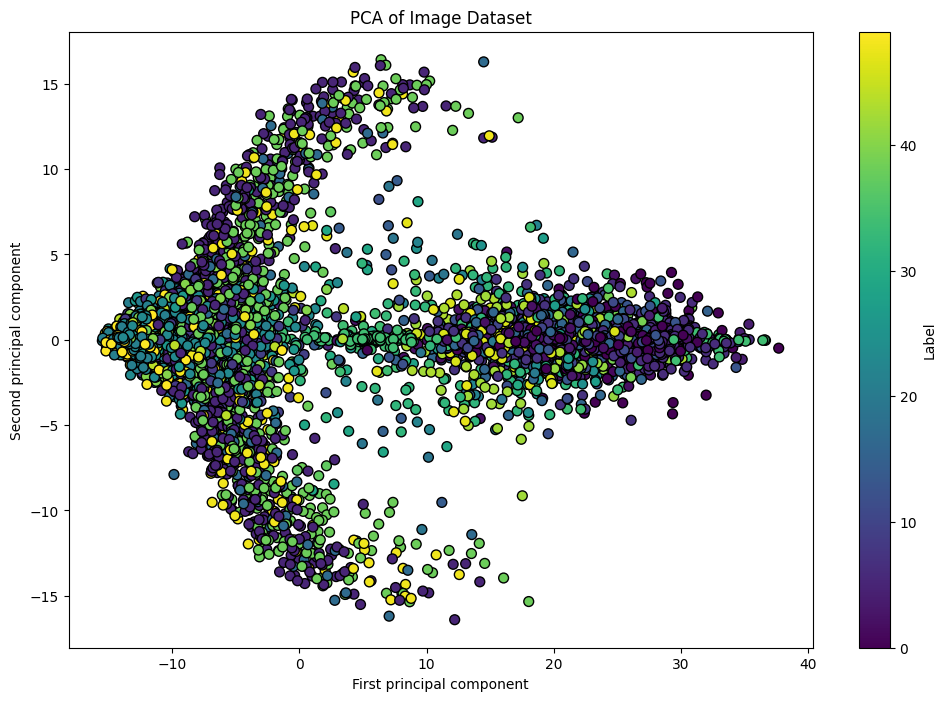

In [ ]:

class TaskDataset(Dataset):
    def __init__(self, data, transform=None):
        self.ids = data.ids
        self.imgs = data.imgs
        self.labels = data.labels
        self.transform = transform if transform is not None else transforms.Compose([
            transforms.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
            transforms.ToTensor()
        ])

    def __getitem__(self, index) -> Tuple[int, torch.Tensor, int]:
        id_ = self.ids[index]
        img = self.imgs[index]
        img = self.transform(img)
        label = self.labels[index]
        return id_, img, label

    def __len__(self):
        return len(self.ids)

class ModelStealingData(TaskDataset):
    def __init__(self, data, transform=None):
        super().__init__(data, transform)

# dataset load
data_model_stealing = '/content/drive/MyDrive/TML_EncoderStealing/ModelStealingPub.pt'
data = torch.load(data_model_stealing)
dataset = ModelStealingData(data)
dataloader = DataLoader(dataset, batch_size=len(dataset))

# extracting images and labels from the dataset
data_iter = iter(dataloader)
ids, imgs, labels = next(data_iter)

#type of labels
print(type(labels))
print(labels)

# labels converted to a list or numpy array
if isinstance(labels, tuple):
    labels_np = np.array(labels)
else:
    labels_np = labels.numpy()

# images to numpy array and flatten
imgs_np = imgs.numpy().reshape(len(imgs), -1)

# mapping labels to integers
if labels_np.dtype.kind in {'U', 'S'}:
    unique_labels = list(set(labels_np))
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    labels_np = np.array([label_map[label] for label in labels_np])
else:
    unique_labels = np.unique(labels_np)
    label_map = {label: idx for idx, label in enumerate(unique_labels)}

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(imgs_np)

# projection by PCA
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_np, cmap='viridis', edgecolor='k', s=50)
plt.title('PCA of Image Dataset')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.colorbar(scatter, label='Label')
plt.show()




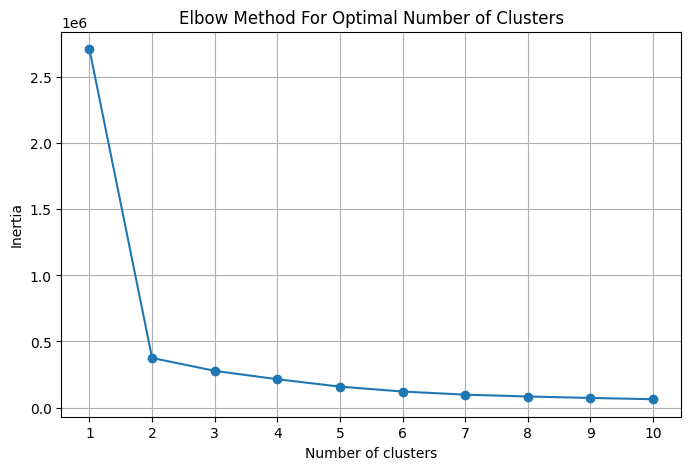

In [ ]:
#We need to find the optimal number of clusters to cluster the feature vectors. We use Elbow method to do it
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# K-Means clustering for different numbers of clusters
inertia = []
range_n_clusters = range(1, 11)
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

#Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means Silhouette Score: 0.78534334897995


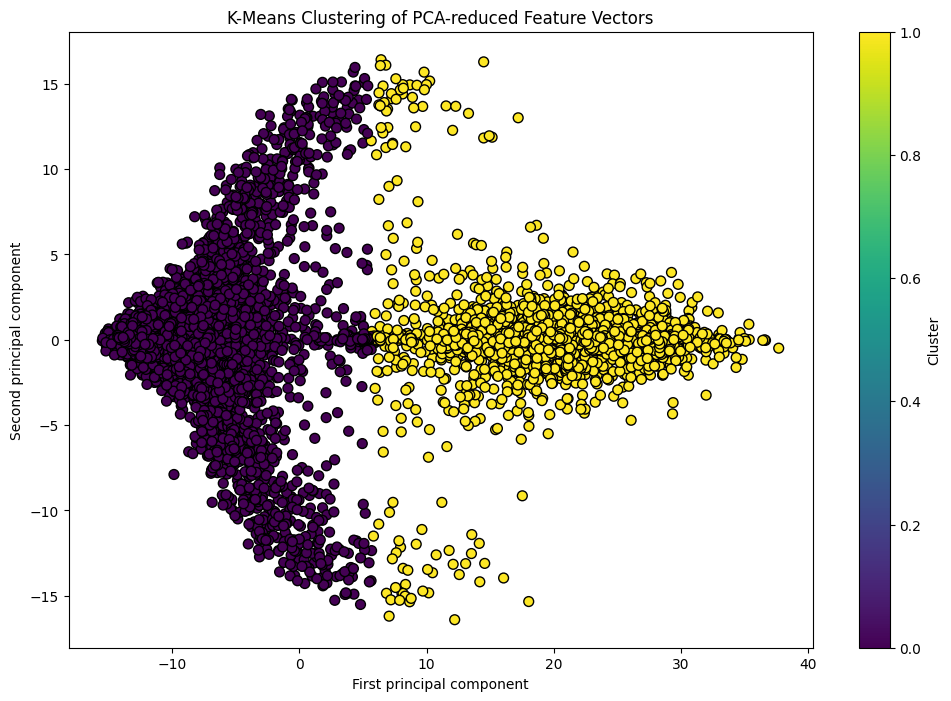

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

#Elbow Method shows that the optimal cluster number for this data is 2 and high K-Means Silhouette score confirms it

# K-Means Clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_pca)
kmeans_labels = kmeans.labels_



#silhouette scores
kmeans_silhouette = silhouette_score(X_pca, kmeans_labels)


print(f"K-Means Silhouette Score: {kmeans_silhouette}")

# Plotting the K-Means clusters
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', edgecolor='k', s=50)
plt.title('K-Means Clustering of PCA-reduced Feature Vectors')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.colorbar(label='Cluster')
plt.show()



In [ ]:
!pip install datasketch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.5 MB/s eta 0:00:00


In [ ]:
from datasketch import MinHash, MinHashLSH
import numpy as np
from sklearn.cluster import KMeans

num_hashes = 256  # Number of hash functions
lsh_threshold = 0.5  # Threshold for Local sensitive hashing (used in paper)
num_buckets = 2**12  # 2^12 hash buckets (optimal number of buckets used in paper)

lsh_individual = MinHashLSH(threshold=lsh_threshold, num_perm=num_hashes)
lsh_centroids = MinHashLSH(threshold=lsh_threshold, num_perm=num_hashes)


optimal_clusters = 2
kmeans = KMeans(n_clusters=optimal_clusters, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)
centroids = kmeans.cluster_centers_

#hash centroids to LSH
centroid_hashes = []
for i, centroid in enumerate(centroids):
    minhash = MinHash(num_perm=num_hashes)
    for dimension in centroid:
        minhash.update(dimension.tobytes())
    centroid_hashes.append(minhash)
    lsh_centroids.insert(f"centroid_{i}", minhash)

print("LSH Hashing of Cluster Centroids completed.")

#hash individual feature vectors to LSH
feature_vector_hashes = []
for i, vector in enumerate(X_pca):
    minhash = MinHash(num_perm=num_hashes)
    for dimension in vector:
        minhash.update(dimension.tobytes())
    feature_vector_hashes.append(minhash)
    lsh_individual.insert(f"vector_{i}", minhash)

print("LSH Hashing of Individual Feature Vectors completed.")


LSH Hashing of Cluster Centroids completed.
LSH Hashing of Individual Feature Vectors completed.


In [ ]:
#tracking unique hash buckets for individual feature vectors by cluster
occupied_buckets_by_cluster = {i: set() for i in range(optimal_clusters)}

for i, vector in enumerate(X_pca):
    minhash = MinHash(num_perm=num_hashes)
    for dimension in vector:
        minhash.update(dimension.tobytes())
    cluster_id = kmeans_labels[i]
    occupied_buckets_by_cluster[cluster_id].update(lsh_individual.query(minhash))

print("LSH Hashing of Individual Feature Vectors completed by cluster.")

#tracking unique hash buckets for centroids
occupied_buckets_centroids = set()
for minhash in centroid_hashes:
    bucket = lsh_centroids.query(minhash)
    occupied_buckets_centroids.update(bucket)


total_possible_buckets = lsh_individual.b

#fraction of occupied buckets for centroids
coverage_fraction_centroids = len(occupied_buckets_centroids) / total_possible_buckets

#fraction of occupied buckets for individual vectors by cluster
coverage_fractions_individual_by_cluster = {}
for cluster_id, occupied_buckets in occupied_buckets_by_cluster.items():
    coverage_fraction_individual = len(occupied_buckets) / total_possible_buckets
    coverage_fractions_individual_by_cluster[cluster_id] = coverage_fraction_individual

#comparison
print(f"Coverage fraction of the embedding space by cluster centroids: {coverage_fraction_centroids:.4f}")
print("Coverage fraction of the embedding space by individual feature vectors in each cluster:")
for cluster_id, coverage_fraction in coverage_fractions_individual_by_cluster.items():
    print(f"Cluster {cluster_id}: {coverage_fraction:.4f}")


LSH Hashing of Individual Feature Vectors completed by cluster.
Coverage fraction of the embedding space by cluster centroids: 0.0476
Coverage fraction of the embedding space by individual feature vectors in each cluster:
Cluster 0: 94.5476
Cluster 1: 214.9762


In [ ]:
#indices for clusters 0 and 1
indices_cluster_0 = np.where(kmeans_labels == 0)[0]
indices_cluster_1 = np.where(kmeans_labels == 1)[0]

# retrieving original images and labels
images_cluster_0 = [imgs[i] for i in indices_cluster_0]
labels_cluster_0 = [labels_np[i] for i in indices_cluster_0]

images_cluster_1 = [imgs[i] for i in indices_cluster_1]
labels_cluster_1 = [labels_np[i] for i in indices_cluster_1]

#custom dataset class for saving
class ClusterDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


#datasets for cluster 0 and cluster 1 (subsets of the original dataset)
dataset_cluster_0 = ClusterDataset(images_cluster_0, labels_cluster_0)
dataset_cluster_1 = ClusterDataset(images_cluster_1, labels_cluster_1)

#paths in Google Drive
drive_path_cluster_0 = '/content/drive/MyDrive/dataset_cluster_0.pt'
drive_path_cluster_1 = '/content/drive/MyDrive/dataset_cluster_1.pt'

# Saving datasets as .pt files in Google Drive
torch.save(dataset_cluster_0, drive_path_cluster_0)
torch.save(dataset_cluster_1, drive_path_cluster_1)

print("Datasets for cluster 0 and cluster 1 saved to Google Drive as .pt files.")

Datasets for cluster 0 and cluster 1 saved to Google Drive as .pt files.


Datasets for cluster 0 and cluster 1 loaded successfully.


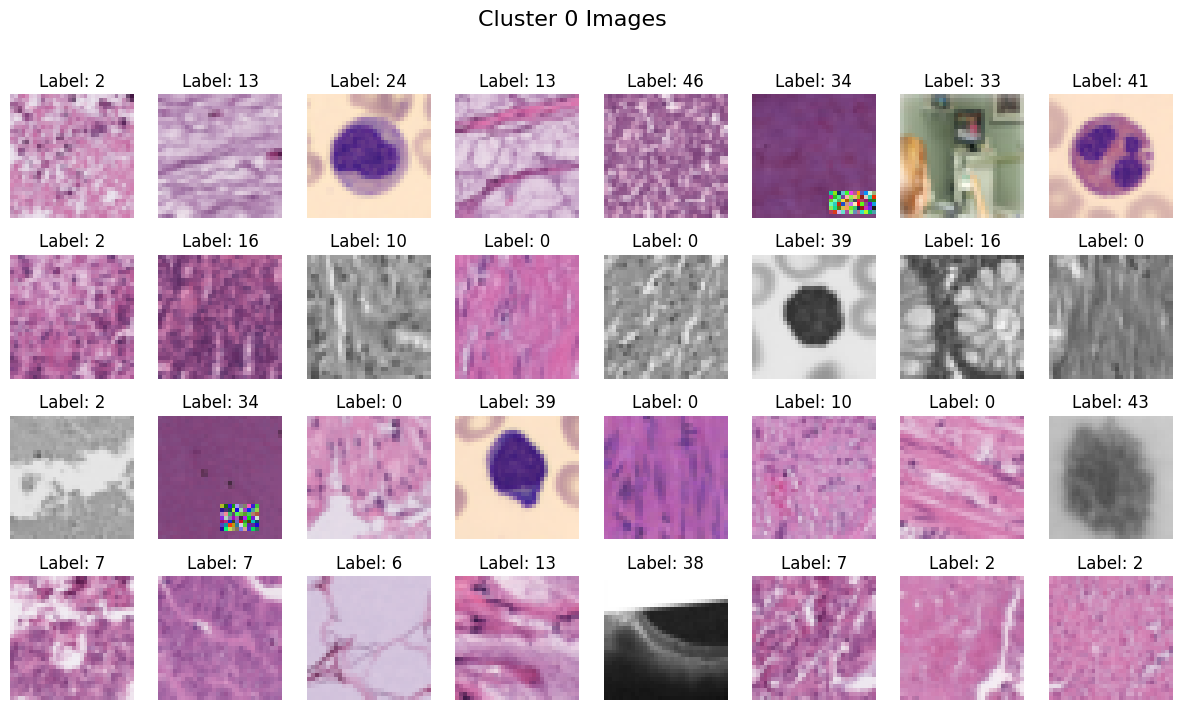

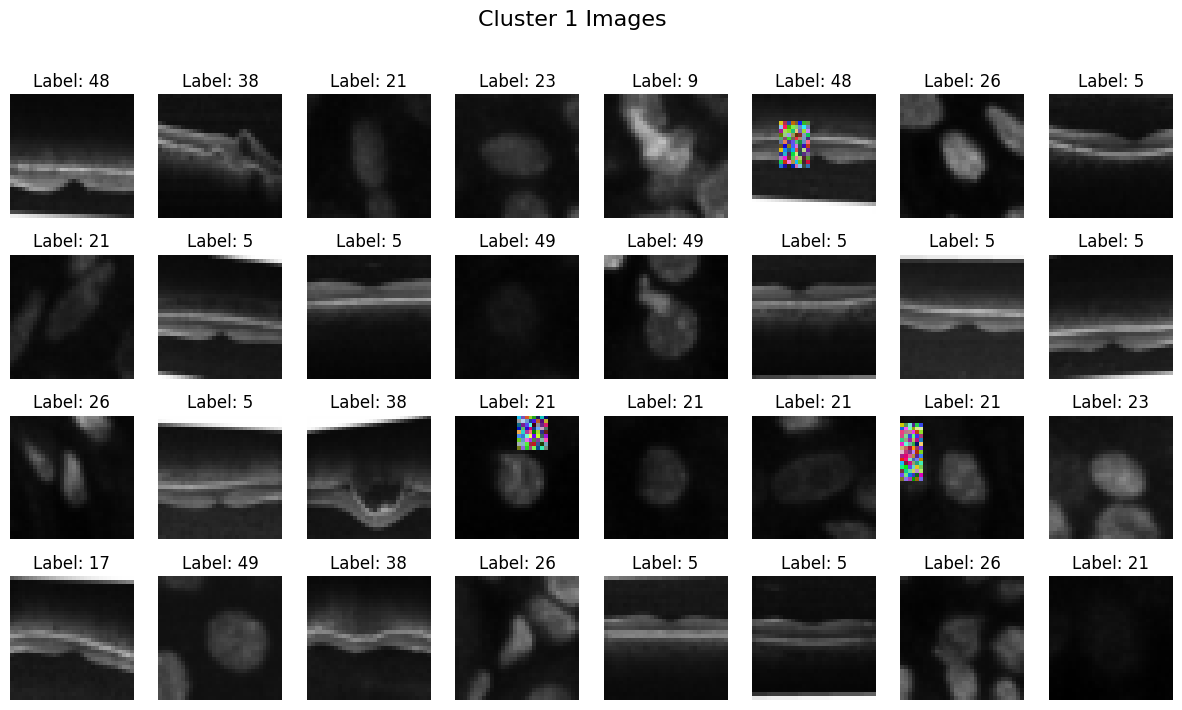

In [ ]:
# Creating DataLoaders
dataloader_cluster_0 = DataLoader(dataset_cluster_0, batch_size=32, shuffle=True)
dataloader_cluster_1 = DataLoader(dataset_cluster_1, batch_size=32, shuffle=True)

print("Datasets for cluster 0 and cluster 1 loaded successfully.")

#function to plot images
def plot_images(images, labels, title):
    fig, axes = plt.subplots(4, 8, figsize=(15, 8))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            image = images[i].permute(1, 2, 0)
            ax.imshow(image)
            ax.set_title(f"Label: {labels[i]}")
            ax.axis('off')
    plt.show()

# images from cluster 0
images_batch_0, labels_batch_0 = next(iter(dataloader_cluster_0))
plot_images(images_batch_0, labels_batch_0, "Cluster 0 Images")

# mages from cluster 1
images_batch_1, labels_batch_1 = next(iter(dataloader_cluster_1))
plot_images(images_batch_1, labels_batch_1, "Cluster 1 Images")

In [ ]:
representations = torch.load(encoder_rep)


print("Shape of loaded feature vectors:", representations.shape)

Shape of loaded feature vectors: torch.Size([12, 1000, 1024])


In [ ]:

batch_size, num_vectors, vector_dim = representations.shape
feature_vectors = representations.reshape(batch_size * num_vectors, vector_dim).numpy()
print("Shape of loaded feature vectors:", feature_vectors.shape)

Shape of loaded feature vectors: (12000, 1024)


In [ ]:
simsiam_representations = torch.load(encoder_rep)

simsiam_feature_vectors = simsiam_representations.reshape(batch_size * num_vectors, vector_dim).numpy()


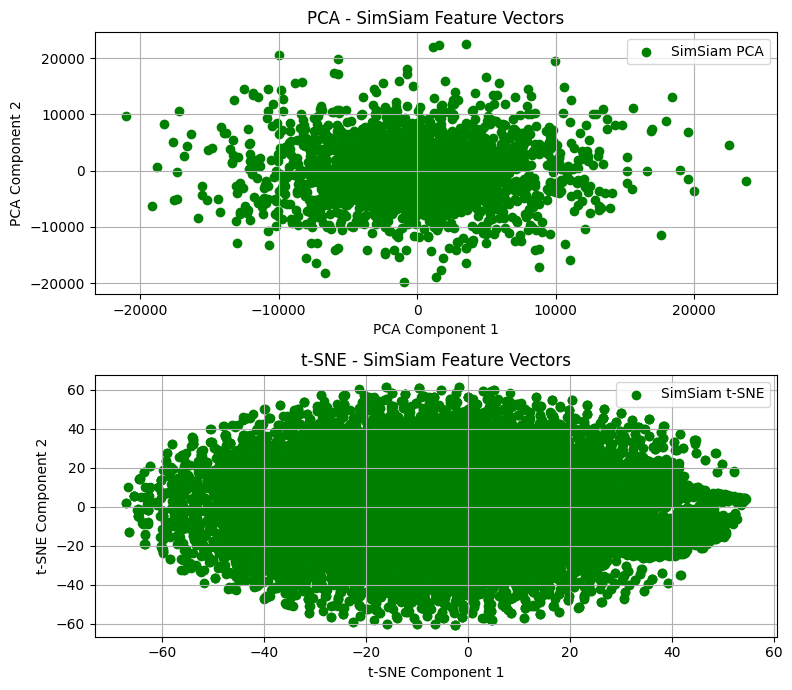

In [ ]:
# PCA
pca = PCA(n_components=2)

simsiam_pca_result = pca.fit_transform(simsiam_feature_vectors)

#t-SNE
tsne = TSNE(n_components=2, random_state=42)

simsiam_tsne_result = tsne.fit_transform(simsiam_feature_vectors)

#PCA results
plt.figure(figsize=(15, 7))



plt.subplot(2, 2, 2)
plt.scatter(simsiam_pca_result[:, 0], simsiam_pca_result[:, 1], c='green', marker='o', label='SimSiam PCA')
plt.title('PCA - SimSiam Feature Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.legend()

#t-SNE results


plt.subplot(2, 2, 4)
plt.scatter(simsiam_tsne_result[:, 0], simsiam_tsne_result[:, 1], c='green', marker='o', label='SimSiam t-SNE')
plt.title('t-SNE - SimSiam Feature Vectors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Example parameters
E_f_U = 0.9  # Estimated coverage fraction
lambda_val = 1 # Adjust based on your requirements
alpha = 5  # Set as target penalty
beta = 0.9  # Set for specific fraction of filled buckets

# Compute sigma based on the provided formula
sigma = lambda_val * (np.exp(np.log(alpha) * E_f_U * beta - 1) - 1)
print(f"Computed Sigma: {sigma}")


Computed Sigma: 0.35478762681732134


In [ ]:
#array of indices
indices = np.arange(len(X_pca))
selected_indices = np.random.choice(indices, size=12000, replace=False)
reduced_feature_vectors = X_pca[selected_indices]


In [ ]:
#estimate noise by calculating difference between original and noisy feature vectors
estimated_noise = simsiam_pca_result - reduced_feature_vectors

#mean and standard deviation of the estimated noise
mean_noise = np.mean(estimated_noise)
std_noise = np.std(estimated_noise)
print(f"Estimated Noise - Mean: {mean_noise}, Std Dev: {std_noise}")

Estimated Noise - Mean: -0.002729004016146064, Std Dev: 2519.359130859375


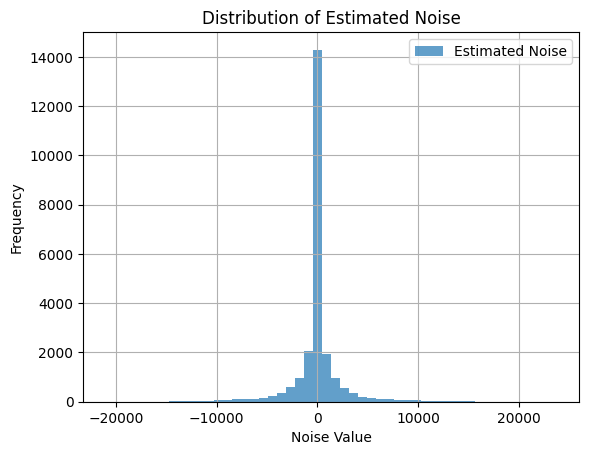

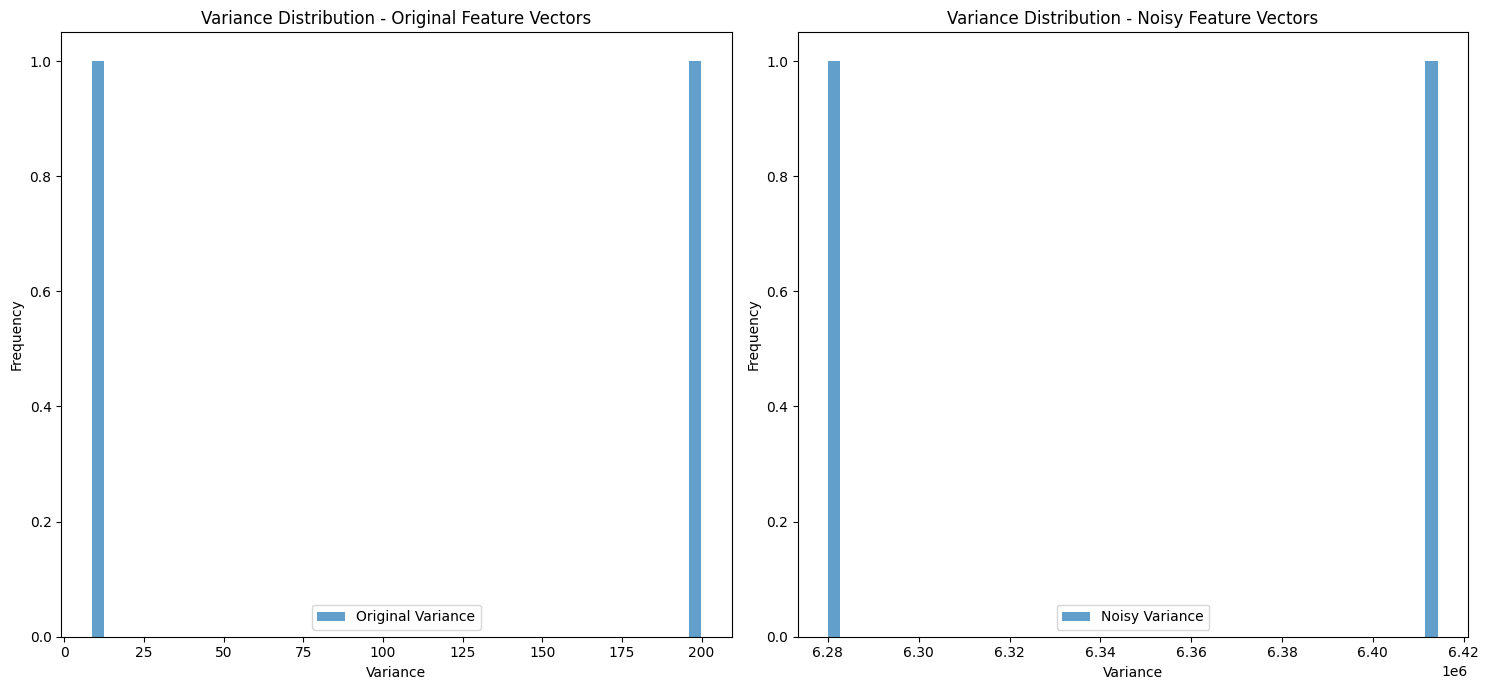

In [ ]:
estimated_noise = simsiam_pca_result - reduced_feature_vectors

# Histogram of noise
plt.hist(estimated_noise.flatten(), bins=50, alpha=0.7, label='Estimated Noise')
plt.title('Distribution of Estimated Noise')
plt.xlabel('Noise Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Variance comparison
original_variance = np.var(reduced_feature_vectors, axis=0)
noisy_variance = np.var(simsiam_pca_result, axis=0)

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.hist(original_variance, bins=50, alpha=0.7, label='Original Variance')
plt.title('Variance Distribution - Original Feature Vectors')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(noisy_variance, bins=50, alpha=0.7, label='Noisy Variance')
plt.title('Variance Distribution - Noisy Feature Vectors')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from scipy.ndimage import gaussian_filter

#Gaussian filter to denoise the obtained feature vectors from target encoder
sigma_noise = np.std(estimated_noise)
denoised_feature_vectors = gaussian_filter(simsiam_feature_vectors,  sigma=sigma_noise)

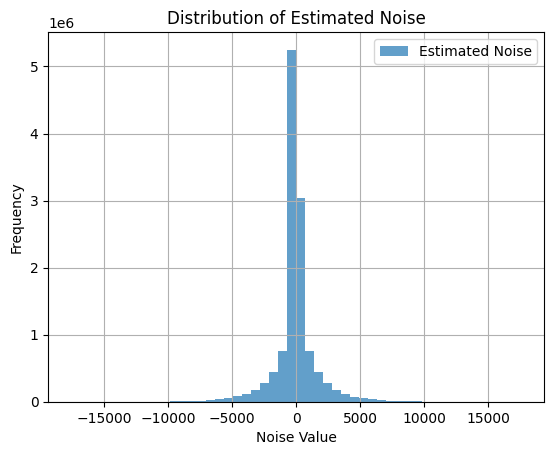

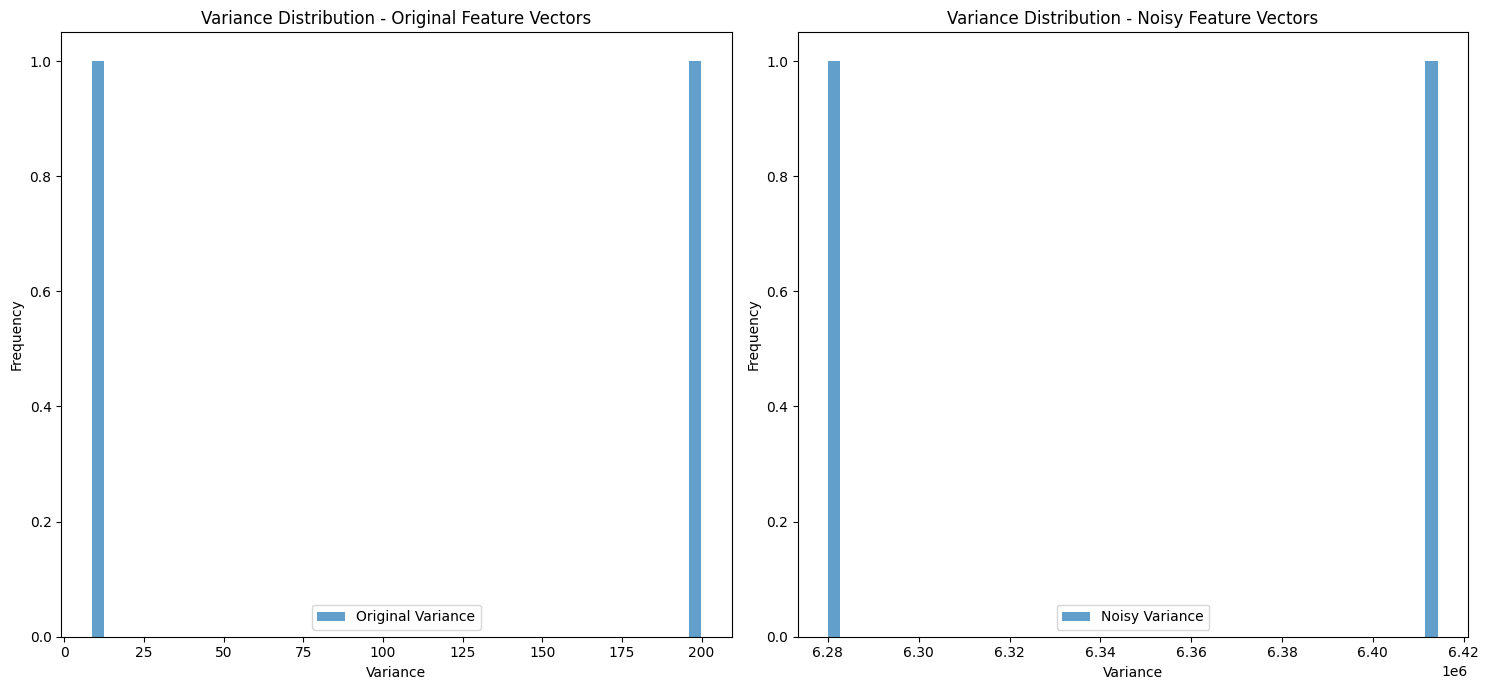

In [ ]:
estimated_noise = denoised_feature_vectors - feature_vectors

# Histogram of noise
plt.hist(estimated_noise.flatten(), bins=50, alpha=0.7, label='Estimated Noise')
plt.title('Distribution of Estimated Noise')
plt.xlabel('Noise Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Variance comparison
original_variance = np.var(reduced_feature_vectors, axis=0)
noisy_variance = np.var(simsiam_pca_result, axis=0)

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.hist(original_variance, bins=50, alpha=0.7, label='Original Variance')
plt.title('Variance Distribution - Original Feature Vectors')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(noisy_variance, bins=50, alpha=0.7, label='Noisy Variance')
plt.title('Variance Distribution - Noisy Feature Vectors')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:

mean_noise = np.mean(estimated_noise)
std_noise = np.std(estimated_noise)
print(f"Estimated Noise - Mean: {mean_noise}, Std Dev: {std_noise}")

Estimated Noise - Mean: 1.525878978725359e-08, Std Dev: 1619.4832763671875


In [ ]:
pca = PCA(n_components=2)
denoised_pca_result = pca.fit_transform(denoised_feature_vectors)

In [ ]:
estimated_noise_filter = denoised_feature_vectors - reduced_feature_vectors
# Calculate mean and standard deviation of the estimated noise
mean_noise = np.mean(estimated_noise_filter)
std_noise = np.std(estimated_noise_filter)
print(f"Estimated Noise - Mean: {mean_noise}, Std Dev: {std_noise}")


Estimated Noise - Mean: -0.002724466845393181, Std Dev: 10.243374824523926


In [ ]:
expected_shape = (12, 1000, 1024)

if denoised_feature_vectors.shape != expected_shape:

    denoised_feature_vectors = np.reshape(denoised_feature_vectors, expected_shape)

print(f"Denoised feature vectors shape: {denoised_feature_vectors.shape}")

#PyTorch tensor
denoised_feature_vectors_tensor = torch.tensor(denoised_feature_vectors, dtype=torch.float32)

# file path to save the tensor
denoised_representations_path = '/content/drive/MyDrive/denoised_feature_vectors.pt'


torch.save(denoised_feature_vectors_tensor, denoised_representations_path)

print(f"Denoised feature vectors saved to {denoised_representations_path}.")
